In [1]:
## Demonstration of univariate nonstationary growth model (UNGM) 
#
#  Description:
#    In this example various different non-linear filters and smoothers are
#    applied to the univariate nonstationary growth model (UNGM). The 
#    filters used in this demonstration are:
#      * Exted Kalman filter
#      * Unscented Kalman filter (augmented and non-augmented forms)
#      * Bootstrap filter
#      * Gauss-Hermite Kalman filter (degree 10)
#      * Cubature Kalman filter
#    Additionally, the corresponding Rauch-Tung-Striebel smoother results 
#    are also presented.
#
#  References:
#    Refer to the Toolbox documentation for details on the model.
#
#  See also:
#    ukf_predict1, ukf_update1, ukf_predict3, ukf_update3, urts_smooth1,
#    ekf_predict1, ekf_update1, erts_smooth1, ghkf_predict, ghkf_update, 
#    ghrts_smooth, ckf_predict, ckf_update, crts_smooth
#
#  Author:
#    Copyright (C) 2007 Jouni Hartikainen,
#    Updated by Arno Solin (2010).
#
#  Licence:
#    This software is distributed under the GNU General Public 
#    Licence (version 2 or later); please refer to the file 
#    Licence.txt, included with the software, for details.

In [2]:
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact

import os, sys
sys.path.append('../..')

from ungm_f import ungm_f
from ungm_h import ungm_h
from ungm_df_dx import ungm_df_dx
from ungm_dh_dx import ungm_dh_dx
from ungm_d2f_dx2 import ungm_d2f_dx2
from ungm_d2h_dx2 import ungm_d2h_dx2

from gauss_rnd import gauss_rnd
from gauss_pdf import gauss_pdf
from resampstr import resampstr

from ekf_predict1 import ekf_predict1
from ekf_update1 import ekf_update1
from erts_smooth1 import erts_smooth1

from ukf_predict1 import ukf_predict1
from ukf_update1 import ukf_update1
from urts_smooth1 import urts_smooth1

from ukf_predict3 import ukf_predict3
from ukf_update3 import ukf_update3

from ghkf_predict import ghkf_predict
from ghkf_update import ghkf_update
from ghrts_smooth import ghrts_smooth

from ckf_predict import ckf_predict
from ckf_update import ckf_update
from crts_smooth import crts_smooth

This is a demonstration for EKF and UKF using the UNGM model.

In [3]:
## Set up the model parameters

silent = False


# Handles to dynamic and measurement model functions,
# and their derivatives
f_func = ungm_f
h_func = ungm_h
df_func = ungm_df_dx
dh_func = ungm_dh_dx
d2f_func = ungm_d2f_dx2
d2h_func = ungm_d2h_dx2

# Number of samples
n = 500

# Initial state and covariance
x_0 = np.array([.1])[:,None]
P_0 = np.array([[1]])

# Space for measurements
Y = np.zeros((n,1))

# Strengths of perturbations
u_n = np.eye(1)
v_n = np.eye(1)

In [4]:
# Generating real states and measurements...

# Generate the true states with process noise
X = np.zeros((n,1))
X[0] = ungm_f(x_0,1) + gauss_rnd(0,u_n,1)
for i in range(1,n):
    X[i] = f_func(X[i-1],i+1) + gauss_rnd(0,u_n,1)


# Generate the observations with measurement noise
Y_r = h_func(X.T)
Y = (Y_r + gauss_rnd(0,v_n,n)).T

m_ = x_0.shape[0]
y_ = len(Y)

# Parameters for dynamic model. Used by smoothers.
params = np.arange(2,n+2)

## Run the various filters and smoothers

In [5]:
################################################################################
# Filtering with UKF1...
################################################################################

# Initial values and space for non-augmented UKF (UKF1)
M = x_0
P = P_0
MM_UKF1 = np.zeros((y_,m_,1))
PP_UKF1 = np.zeros((y_,m_,m_))

# Filtering loop for UKF1
for k in range(y_):
    M, P, _ = ukf_predict1(M, P, f_func, u_n, k+1)
    M, P, *_ = ukf_update1(M, P, Y[k], h_func, v_n)
    MM_UKF1[k] = M
    PP_UKF1[k] = P    

MMS_URTS1, PPS_URTS1, _ = urts_smooth1(MM_UKF1, PP_UKF1, f_func, u_n, params, None, None, None, None, 0)

# MSE for UKF1
UKF1_MSE = np.sum((X-MM_UKF1[:,0])**2)/n
UKS1_MSE = np.sum((X-MMS_URTS1[:,0])**2)/n

In [6]:
# Filtering with UKF2............................................................

# Initial valuesand space for augmented UKF (UKF2)
M = x_0
P = P_0
MM_UKF2 = np.zeros((y_,m_,1))
PP_UKF2 = np.zeros((y_,m_,m_))

# Filtering loop for UKF2
for k in range(y_):
    M, P, X_s, w, _ = ukf_predict3(M, P, f_func, u_n, v_n, k+1)
    M, P, *_ = ukf_update3(M, P, Y[k], h_func, v_n, X_s, w, None)
    MM_UKF2[k] = M
    PP_UKF2[k] = P    

MMS_URTS2, PPS_URTS2, _ = urts_smooth1(MM_UKF2, PP_UKF2, f_func, u_n, params, None, None, None, None, 0)

# MSE for UKF2
UKF2_MSE = np.sum((X-MM_UKF2[:,0])**2)/n
UKS2_MSE = np.sum((X-MMS_URTS2[:,0])**2)/n

In [7]:
################################################################################
# Filtering with EKF
################################################################################
M = x_0
P = P_0

MM_EKF = np.zeros((y_,m_,1))
PP_EKF = np.zeros((y_,m_,m_))

# Filtering loop for EKF
for k in range(y_):
    M, P = ekf_predict1(M, P, df_func, u_n, f_func, None, k+1)
    M, P, *_ = ekf_update1(M, P, Y[k], dh_func, v_n, h_func, None, None)
    MM_EKF[k] = M
    PP_EKF[k] = P    


MMS_ERTS, PPS_ERTS, _ = erts_smooth1(MM_EKF, PP_EKF, df_func, u_n, f_func, None, params, 0)

EKF_MSE = np.sum((X-MM_EKF[:,0])**2)/n
ERTS_MSE = np.sum((X-MMS_ERTS[:,0])**2)/n

In [8]:
################################################################################
# Filtering with bootstrap filter
################################################################################
M = x_0
P = P_0
n_particles = 1000
SX = gauss_rnd(M, P, n_particles)

MM_BS = np.zeros((y_,m_,1))
PP_BS = np.zeros((y_,m_,m_))

# Filtering loop for bootstrap filter
for k in range(y_):
    SX = ungm_f(SX,k+1) + gauss_rnd(0,1,SX.shape[1])
    W, _ = gauss_pdf(Y[k], ungm_h(SX,k+1), np.eye(1))
    ind = resampstr(W)
    SX = SX[0,ind][None]
    M = np.mean(SX)
    P = np.var(SX)
    MM_BS[k] = M
    PP_BS[k] = P  


BS_MSE = np.sum((X-MM_BS[:,0])**2)/n

In [9]:
################################################################################
# Filtering with GHKF
################################################################################
M = x_0
P = P_0

MM_GHKF = np.zeros((y_,m_,1))
PP_GHKF = np.zeros((y_,m_,m_))

# Filtering loop for GHKF
for k in range(y_):
    M, P = ghkf_predict(M, P, f_func ,u_n, k+1)
    M, P, *_ = ghkf_update(M, P, Y[k], h_func, v_n)
    MM_GHKF[k] = M
    PP_GHKF[k] = P    

MMS_GHRTS, PPS_GHRTS, _ = ghrts_smooth(MM_GHKF, PP_GHKF, f_func, u_n, params, None, 0)

GHKF_MSE = np.sum((X-MM_GHKF[:,0])**2)/n
GHRTS_MSE = np.sum((X-MMS_GHRTS[:,0])**2)/n

In [10]:
################################################################################
# Filtering with CKF
################################################################################
M = x_0
P = P_0

MM_CKF = np.zeros((y_,m_,1))
PP_CKF = np.zeros((y_,m_,m_))

# Filtering loop for CKF
for k in range(y_):
    M, P = ckf_predict(M, P, f_func, u_n, k+1)
    M, P, *_ = ckf_update(M, P, Y[k], h_func, v_n)
    MM_CKF[k]   = M
    PP_CKF[k] = P    

MMS_CRTS, PPS_CRTS, _ = crts_smooth(MM_CKF, PP_CKF, f_func, u_n, params, 0)

CKF_MSE = np.sum((X-MM_CKF[:,0])**2)/n
CRTS_MSE = np.sum((X-MMS_CRTS[:,0])**2)/n

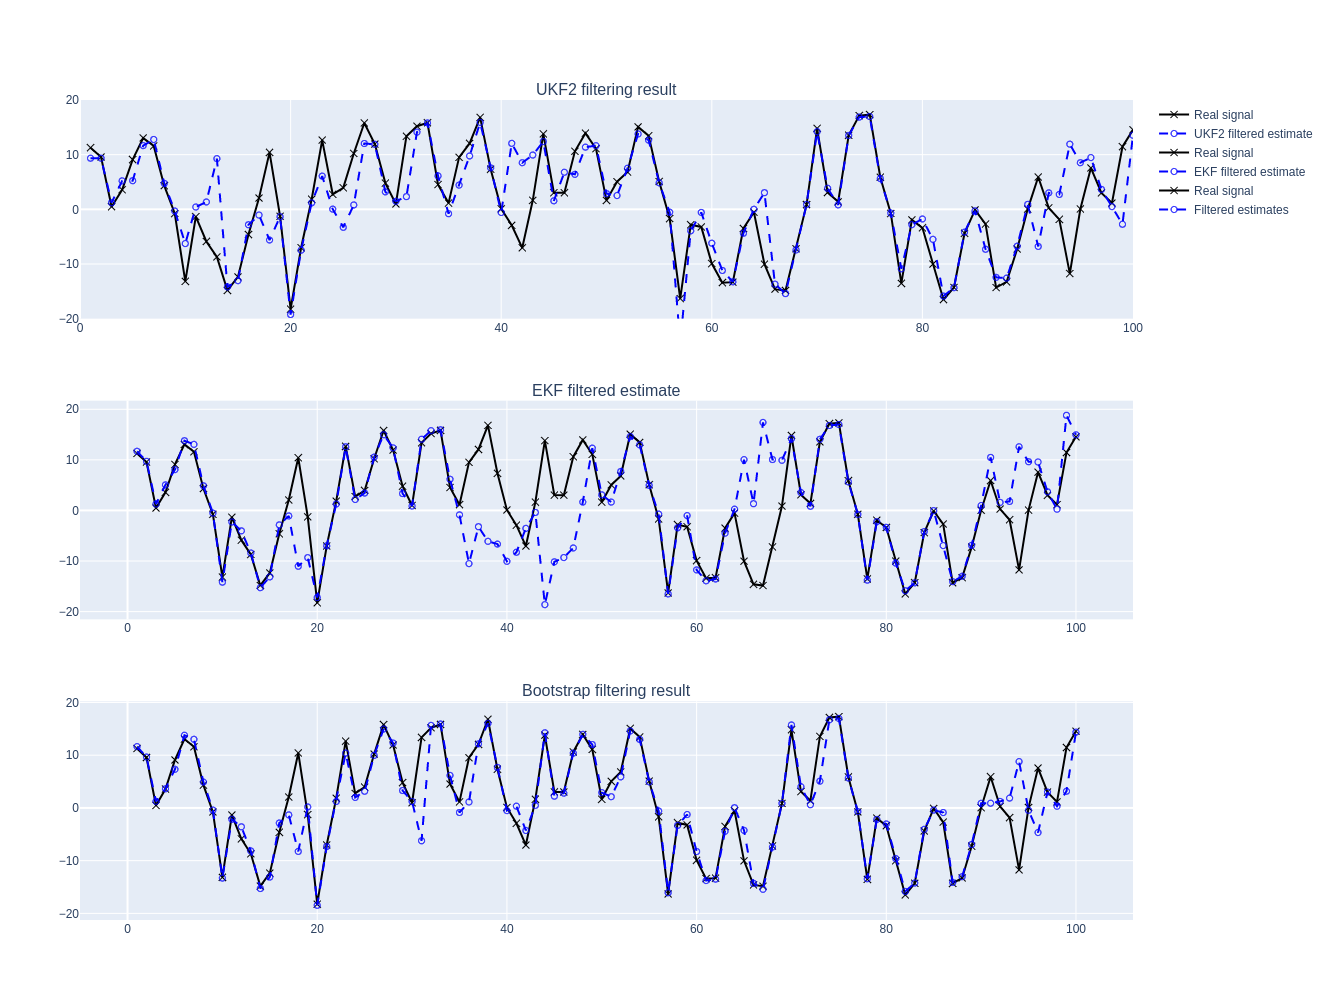

In [11]:
## Visualize results
xs = np.arange(1,101)

if not silent:
    fig = go.Figure(make_subplots(rows=3, cols=1, subplot_titles=['UKF2 filtering result','EKF filtered estimate',
                                                                  'Bootstrap filtering result'], vertical_spacing=0.1))
    fig.add_scatter(x=xs, y=X[:100,0], mode='lines+markers', name='Real signal', line_color='black', marker_size=7, marker_symbol='x-thin-open', row=1, col=1)
    fig.add_scatter(x=xs, y=MM_UKF2[:100,0,0], mode='lines+markers', line_dash='dash', line_color='blue', 
                    marker_symbol='circle-open', name='UKF2 filtered estimate', row=1, col=1)

    fig.add_scatter(x=xs, y=X[:100,0], mode='lines+markers', name='Real signal', line_color='black', marker_size=7, marker_symbol='x-thin-open', row=2, col=1)
    fig.add_scatter(x=xs, y=MM_EKF[:100,0,0], mode='lines+markers', line_dash='dash', line_color='blue', 
                    marker_symbol='circle-open', name='EKF filtered estimate', row=2, col=1)

    fig.add_scatter(x=xs, y=X[:100,0], mode='lines+markers', name='Real signal', line_color='black', marker_size=7, marker_symbol='x-thin-open', row=3, col=1)
    fig.add_scatter(x=xs, y=MM_BS[:100,0,0], mode='lines+markers', line_dash='dash', line_color='blue', 
                    marker_symbol='circle-open', name='Filtered estimates', row=3, col=1)

    fig.layout.update(xaxis_range=[0,100], yaxis_range=[-20,20], height=1000)
    fig.show()

First 100 values of the filtering results with UKF2, EKF and BS are now displayed.

Notice how the BS gives clearly better performance than UKF2 and EKF.

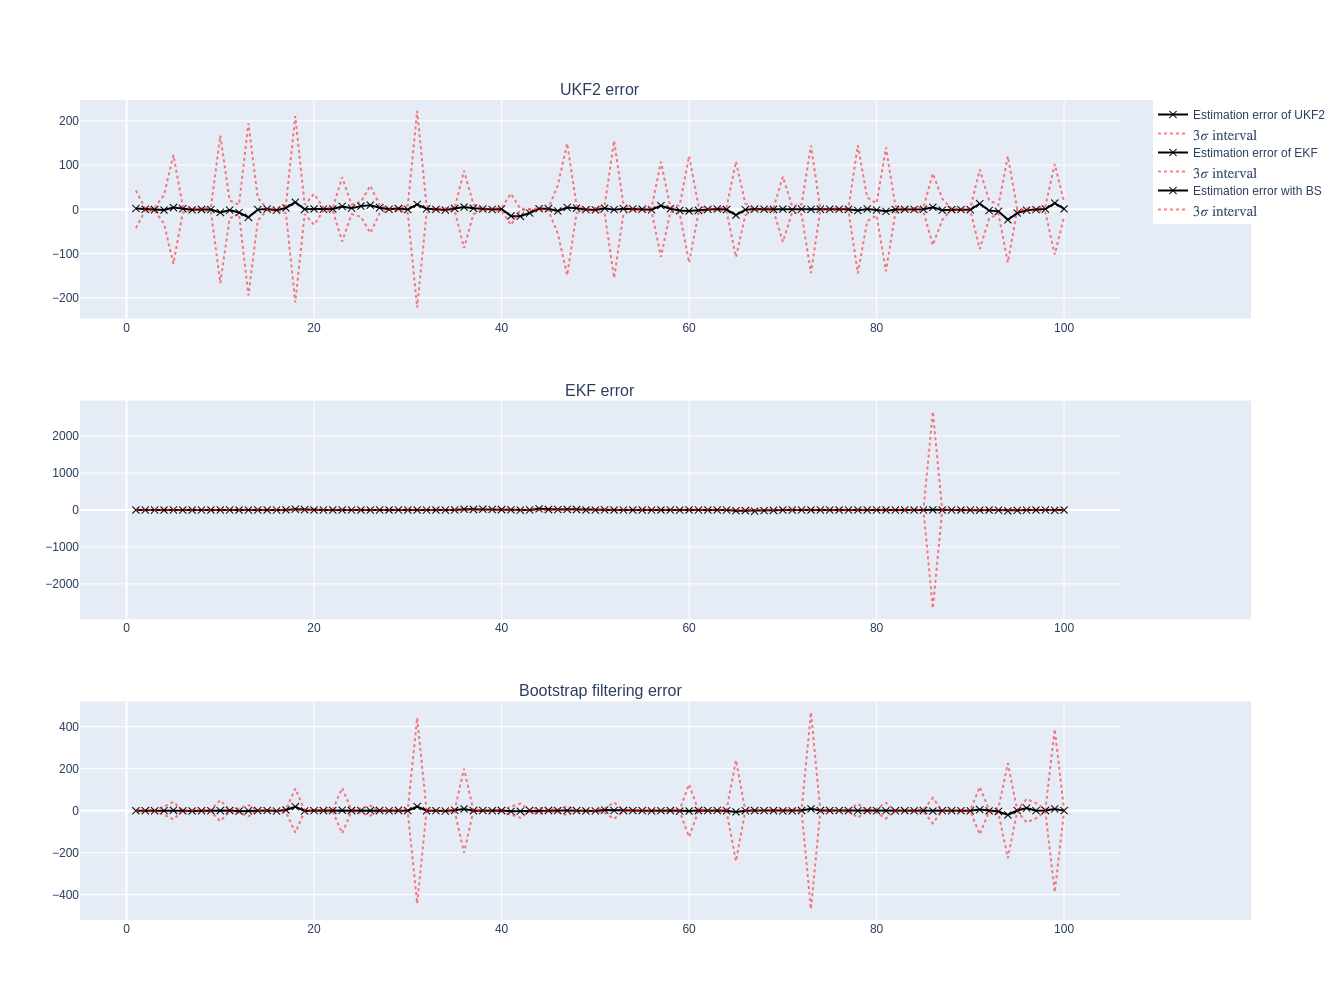

In [12]:
if not silent:
    fig = go.Figure(make_subplots(rows=3, cols=1, subplot_titles=['UKF2 error','EKF error','Bootstrap filtering error'], vertical_spacing=0.1))
    E = X[:,0]-MM_UKF2[:,0,0]
    fig.add_scatter(x=xs, y=E[:100], mode='lines+markers', line_color='black', marker_size=7, 
                    marker_symbol='x-thin-open', name='Estimation error of UKF2', row=1, col=1)
    fig.add_scatter(x=xs, y=3*PP_UKF2[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', row=1, col=1)
    fig.add_scatter(x=xs, y=-3*PP_UKF2[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', showlegend=False, row=1, col=1)

    E = X[:,0]-MM_EKF[:,0,0]
    fig.add_scatter(x=xs, y=E[:100], mode='lines+markers', line_color='black', marker_size=7, 
                    marker_symbol='x-thin-open', name='Estimation error of EKF', row=2, col=1)
    fig.add_scatter(x=xs, y=3*PP_EKF[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', row=2, col=1)
    fig.add_scatter(x=xs, y=-3*PP_EKF[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', showlegend=False, row=2, col=1)

    E = X[:,0]-MM_BS[:,0,0]
    fig.add_scatter(x=xs, y=E[:100], mode='lines+markers', line_color='black', marker_size=7, 
                    marker_symbol='x-thin-open', name='Estimation error with BS', row=3, col=1)
    fig.add_scatter(x=xs, y=3*PP_BS[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', row=3, col=1)
    fig.add_scatter(x=xs, y=-3*PP_BS[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', showlegend=False, row=3, col=1)

    fig.layout.update(height=1000)
    fig.show()

The estimation errors of UKF2, EKF and BS are now displayed.
The superiority of BS can easily be seen also from this.

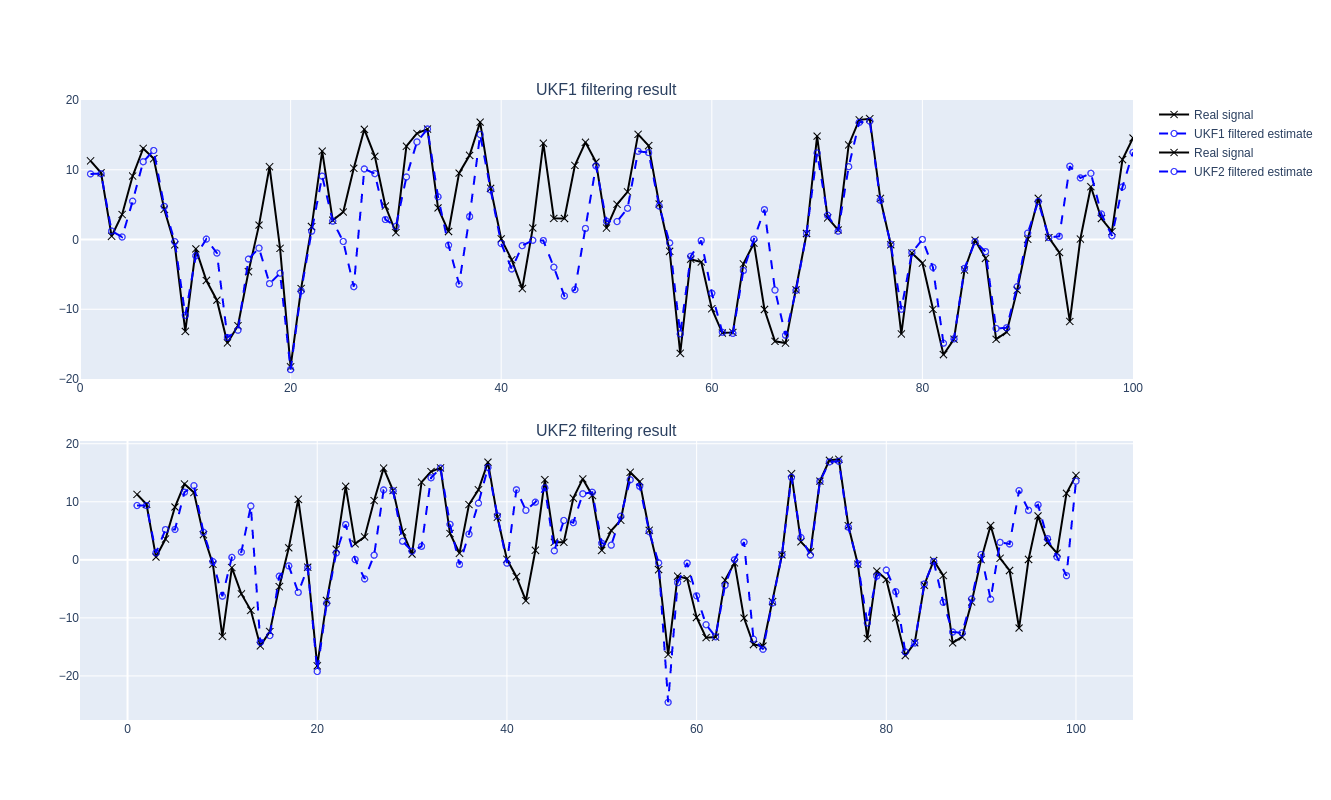

In [13]:
if not silent:
    fig = go.Figure(make_subplots(rows=2, cols=1, subplot_titles=['UKF1 filtering result','UKF2 filtering result'], vertical_spacing=0.1))

    fig.add_scatter(x=xs, y=X[:100,0], mode='lines+markers', line_color='black', marker_size=7, marker_symbol='x-thin-open', name='Real signal', row=1, col=1)
    fig.add_scatter(x=xs, y=MM_UKF1[:100,0,0], mode='lines+markers', line=dict(dash='dash', color='blue'), marker_symbol='circle-open',
                    name='UKF1 filtered estimate', row=1, col=1)

    fig.add_scatter(x=xs, y=X[:100,0], mode='lines+markers', line_color='black', marker_size=7, marker_symbol='x-thin-open', name='Real signal', row=2, col=1)
    fig.add_scatter(x=xs, y=MM_UKF2[:100,0,0], mode='lines+markers', line=dict(dash='dash', color='blue'), marker_symbol='circle-open',
                    name='UKF2 filtered estimate', row=2, col=1)

    fig.layout.update(xaxis_range=[0,100], yaxis_range=[-20,20], height=800)
    fig.show()

First 100 values of the filtering results with UKF1 and UKF2 are now displayed.

Clearly the non-augmented UKF is not applicable to this problem.

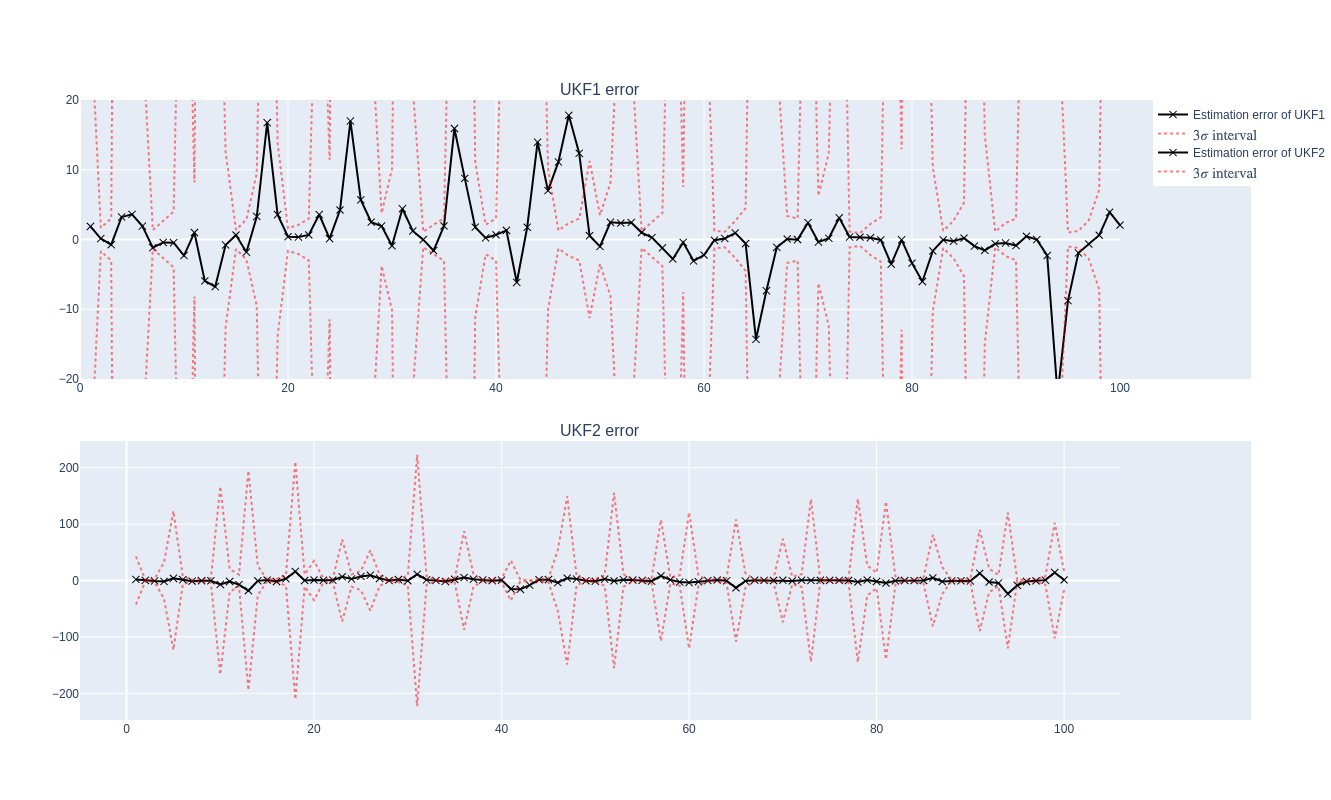

In [14]:
if not silent:
    fig = go.Figure(make_subplots(rows=2, cols=1, subplot_titles=['UKF1 error','UKF2 error'], vertical_spacing=0.1))

    E = X[:,0]-MM_UKF1[:,0,0]
    fig.add_scatter(x=xs, y=E[:100], mode='lines+markers', line_color='black', marker_size=7, marker_symbol='x-thin-open', 
                    name='Estimation error of UKF1', row=1, col=1)
    fig.add_scatter(x=xs, y=3*PP_UKF1[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', row=1, col=1)
    fig.add_scatter(x=xs, y=-3*PP_UKF1[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', showlegend=False, row=1, col=1)

    E = X[:,0]-MM_UKF2[:,0,0]
    fig.add_scatter(x=xs, y=E[:100], mode='lines+markers', line_color='black', marker_size=7, marker_symbol='x-thin-open', 
                    name='Estimation error of UKF2', row=2, col=1)
    fig.add_scatter(x=xs, y=3*PP_UKF2[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', row=2, col=1)
    fig.add_scatter(x=xs, y=-3*PP_UKF2[:100,0,0], line=dict(dash='dot', color='red'), opacity=0.5, name='$3 \sigma \\text{ interval}$', showlegend=False, row=2, col=1)

    fig.layout.update(xaxis_range=[0,100], yaxis_range=[-20,20], height=800)
    fig.show()

The absolute estimation errors of UKF1 and UKF2 are now displayed.

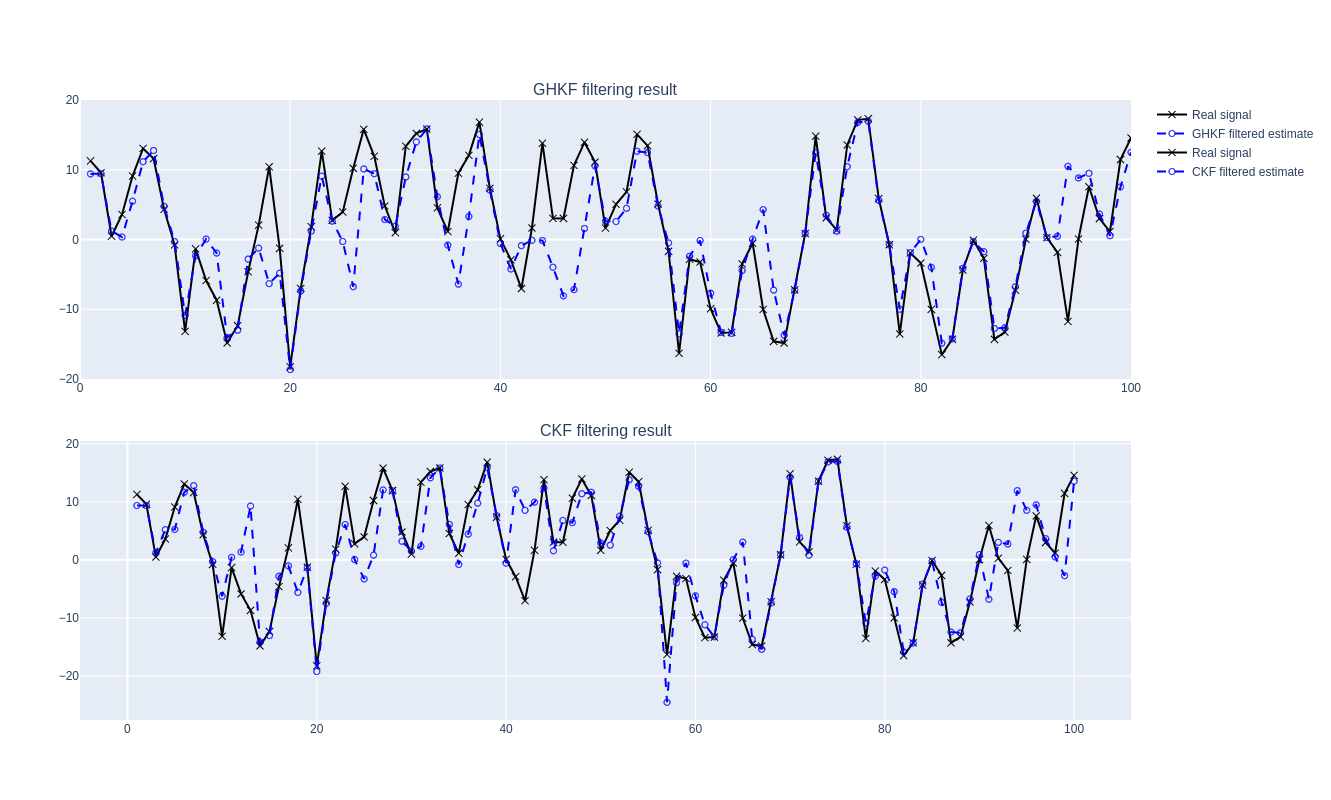

In [15]:
if not silent:
    fig = go.Figure(make_subplots(rows=2, cols=1, subplot_titles=['GHKF filtering result','CKF filtering result'], vertical_spacing=0.1))

    fig.add_scatter(x=xs, y=X[:100,0], mode='lines+markers', line_color='black', marker_size=7, marker_symbol='x-thin-open', name='Real signal', row=1, col=1)
    fig.add_scatter(x=xs, y=MM_UKF1[:100,0,0], mode='lines+markers', line=dict(dash='dash', color='blue'), 
                    marker_symbol='circle-open', name='GHKF filtered estimate', row=1, col=1)

    fig.add_scatter(x=xs, y=X[:100,0], mode='lines+markers', line_color='black', marker_size=7, marker_symbol='x-thin-open', name='Real signal', row=2, col=1)
    fig.add_scatter(x=xs, y=MM_UKF2[:100,0,0], mode='lines+markers', line=dict(dash='dash', color='blue'), 
                    marker_symbol='circle-open', name='CKF filtered estimate', row=2, col=1)

    fig.layout.update(xaxis_range=[0,100], yaxis_range=[-20,20], height=800)
    fig.show()

First 100 values of the filtering results with GHKF (10 th degree) and CKF are now displayed.

Clearly the non-augmented UKF is not applicable to this problem.

In [16]:
# Show RMSE errors for each method
if not silent:
    print('MS ERRORS:')
    print('  UKF1-MSE = {:2f}\n  UKS1-MSE = {:2f}\n  UKF2-MSE = {:2f}\n\
  UKS2-MSE = {:2f}\n  EKF-MSE  = {:2f}\n  ERTS-MSE = {:2f}\n\
  BS-MSE   = {:2f}\n\nCurbature Methods:\n  GHKF-MSE  = {:2f}\n\
  GHRTS-MSE = {:2f}\n  CKF-MSE   = {:2f}\n  CRTS-MSE  = {:2f}\n'.format(*[UKF1_MSE, UKS1_MSE, UKF2_MSE, UKS2_MSE, EKF_MSE, 
                                                                          ERTS_MSE, BS_MSE, GHKF_MSE, GHRTS_MSE, CKF_MSE, CRTS_MSE]))

MS ERRORS:
  UKF1-MSE = 41.588869
  UKS1-MSE = 38.704231
  UKF2-MSE = 27.550496
  UKS2-MSE = 19.417545
  EKF-MSE  = 126.313600
  ERTS-MSE = 94.628022
  BS-MSE   = 10.172949

Curbature Methods:
  GHKF-MSE  = 34.058794
  GHRTS-MSE = 25.114938
  CKF-MSE   = 53.853176
  CRTS-MSE  = 47.163574

